# Make Spectra

In [1]:
# BB model:
#   https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html
import numpy as np
import matplotlib.pyplot as plt
import random 
import sys
import pickle

from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

In [2]:
import os
from pathlib import Path

script_path = str(Path().absolute())

path_spectra = script_path+"/spectra_noabs"

if not os.path.exists(path_spectra):
    os.makedirs(path_spectra)
    print('Folder',os.path.basename(path_spectra),'created.')

Folder spectra_noabs created.


In [3]:
def make_spectrum(T_star=6000, N_star=1e-6, T_dust=500, N_dust=1, display=True, save=True):

    param_set = locals()
    del param_set['display']
    del param_set['save']
    # dictionary of input args

    spectrum_root_name = "spectrum_" + ("_".join(
        [param+'_'+str(value) for (param, value) in param_set.items()])
    )
    
    sr = 1e-10
    # steradiants to convert to flux density
    random.seed(42)

    bb_star = BlackBody(temperature=T_star*u.K, scale=N_star)
    bb_dust = BlackBody(temperature=T_dust*u.K, scale=N_dust)
    wave = np.logspace(3, 7, num=100) * u.AA

    # Multiplying by sterad to get flux density:
    flux_star = bb_star(wave) * sr*u.sr
    flux_dust = bb_dust(wave) * sr*u.sr
    flux = flux_star + flux_dust

    # Modulating with noise:
    flux_star_n = flux_star*np.random.uniform(0.5, 1.5, len(flux_star))
    flux_dust_n = flux_dust*np.random.uniform(0.5, 1.5, len(flux_dust))
    flux_n      = flux_star_n + flux_dust_n

    # Converting units:
    wave_mu = (wave).to(u.um)
    flux_star_n_Jy = (flux_star_n).to(u.Jy)
    flux_dust_n_Jy = (flux_dust_n).to(u.Jy)
    flux_n_Jy      = (flux_n).to(u.Jy)

    if display == True:
        with quantity_support():
            plt.figure(figsize=(6,3))
            plt.plot(wave_mu, flux_star_n_Jy, ls='--', c='royalblue',
                     label=str('%4s: N=%-6.0e | T=%sK' % ("star", N_star, T_star)))
            plt.plot(wave_mu, flux_dust_n_Jy, ls='--', c='tomato' ,
                     label=str('%4s: N=%-6.0e | T=%sK' % ("dust", N_dust, T_dust)))
            plt.plot(wave_mu, flux_n_Jy, c = 'mediumseagreen',label='total')
            plt.xscale('log')
            plt.yscale('log')
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
                       ncol=2, fancybox=True, shadow=True)            
            plt.ylim([1e-2, 1e7])
            plt.savefig(path_spectra+'/'+spectrum_root_name+'.png')
            plt.show()
    
    spectrum = {"data": {"wave_mu": np.array(wave_mu),
                         "flux_Jy": np.array(flux_n_Jy),
                         "flux_star_Jy": np.array(flux_star_n_Jy),
                         "flux_dust_Jy": np.array(flux_dust_n_Jy)}
               }
    
    spectrum.update({"metadata": param_set})

    if display == True:
        print('Spectrum size [byte]:', sys.getsizeof(spectrum))
    
    if save:
        with open(path_spectra+'/'+spectrum_root_name+'.pkl', 'wb') as fh:
            pickle.dump(spectrum, fh, protocol=pickle.HIGHEST_PROTOCOL)

    # Load as:
    #with open(path_spectra+'/'+spectrum_root_name+'.pkl', 'rb') as fh:
    #    spectrum = pickle.load(fh)
    
    return spectrum

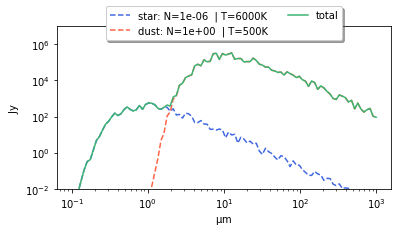

Spectrum size [byte]: 232


In [4]:
spectrum = make_spectrum(save=False)

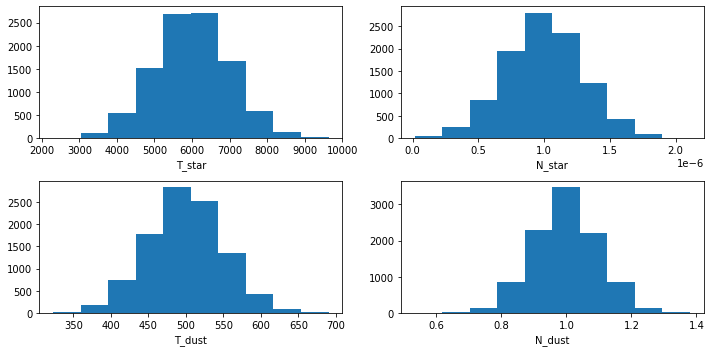

In [5]:
# Grid parameter generation:
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
from scipy.stats import norm

rng = np.random.RandomState(0)
param_grid = {
    'T_star': norm(6000, 1000), 'T_dust': norm(500, 50),
    'N_star': norm(10, 3), 'N_dust': norm(10, 1)
}

n_sets = 10000
# number of parameter sets (== number of spectra) to be generated

param_sets = list(ParameterSampler(param_grid, n_iter=n_sets, random_state=rng))

for param_set in param_sets:
    param_set['T_star'] = int(round(np.abs(param_set['T_star']), 0))
    param_set['T_dust'] = int(round(np.abs(param_set['T_dust']), 0))
    param_set['N_dust'] = float("%.3g" % (np.abs(param_set['N_dust'])*1e-1))
    param_set['N_star'] = float("%.3g" % (np.abs(param_set['N_star'])*1e-7))

L_T_star = [param_set['T_star'] for param_set in param_sets]
L_T_dust = [param_set['T_dust'] for param_set in param_sets]
L_N_dust = [param_set['N_dust'] for param_set in param_sets]
L_N_star = [param_set['N_star'] for param_set in param_sets]

fig, axes = plt.subplots(2,2, figsize=(10,5))

# Row 1:
axes[0,0].hist(L_T_star)
axes[0,0].set_xlabel('T_star')
#
axes[0,1].hist(L_N_star)
axes[0,1].set_xlabel('N_star')

# Row 2:
axes[1,0].hist(L_T_dust)
axes[1,0].set_xlabel('T_dust')
#
axes[1,1].hist(L_N_dust)
axes[1,1].set_xlabel('N_dust')

fig.tight_layout()
plt.savefig('params_distribution.jpg')
plt.show()

In [6]:
%%time
for i, param_set in enumerate(param_sets):
    print('Creating spectrum %5s[/%s]' % (i+1, len(param_sets)), end='\r')
    spectrum = make_spectrum(**param_set, display=False, save=True)

CPU times: user 56.5 s, sys: 1.77 s, total: 58.2 s
Wall time: 53.2 s


In [7]:
###EOF